## **Dual Listing Arbitrage**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Dec 21 12:13:00 2022

@author: Bradley

Sample code for dual listing arbitrage
"""

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from functools import partial
import os

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', True) 
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) #
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


A Project to identify arbitrage opportunities between two stock exchanges trading the same stock. The algorithm searches for the possibility of a mismatch and trades on it. Next to that, it takes into account certain limits, which is set to a max position of 250 to prevent massive losses if the algorithm malfunctions.

In [1]:
# Import pandas and numpy for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set Jupyter to render directly to the screen
%matplotlib inline

In [2]:
def read_data(filename):
    '''
    This reads the .csv stored at the 'filename' location and returns a DataFrame
    with two-level columns. The first level column contains the Exchange and the 
    second contains the type of market data, e.g. bid/ask, price/volume.
    '''
    df = pd.read_csv(filename, index_col=0)
    df.columns = [df.columns.str[-7:], df.columns.str[:-8]]

    return df

In [3]:
# Read the data for one of the stocks
filename = 'HWG.csv'
market_data = read_data(filename)

In [4]:
# Visualization of the columns in the DataFrame
market_data.head()

I-XCHNG                               Z-XCHNG            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00   114.25     120.0   114.55     120.0   113.95      40.0   
2018-01-01 00:10:00   114.05     119.0   114.40     102.0   113.65      42.0   
2018-01-01 00:15:00   114.05     119.0   114.40     105.0   113.30      41.0   
2018-01-01 00:20:00   114.00     116.0   114.40     124.0   113.50      40.0   
2018-01-01 00:25:00   114.00     118.0   114.35     133.0   113.45      43.0   

                                        
                    AskPrice AskVolume  
2018-01-01 00:05:00   114.85      40.0  
2018-01-01 00:10:00   114.60      36.0  
2018-01-01 00:15:00   114.35      35.0  
2018-01-01 00:20:00   114.55      37.0  
2018-01-01 00:25:00   114.40      33.0

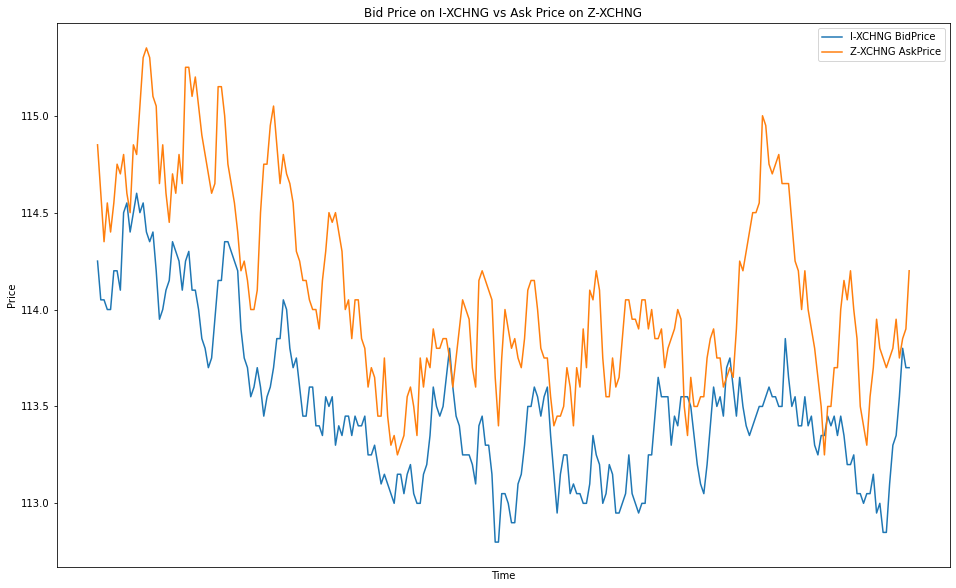

In [5]:
# Select the first 250 rows
market_data_250 = market_data.iloc[:250]

# Set figsize of plot
plt.figure(figsize=(16, 10))

# Create a plot showing the bid and ask prices on different exchanges
def Plot_Bid_Ask(stock1 = 'I-XCHNG', stock2 = 'Z-XCHNG'):
    plt.plot(market_data_250.index, market_data_250[stock1, 'BidPrice'])
    plt.plot(market_data_250.index, market_data_250[stock2, 'AskPrice'])
    plt.xticks([])
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Bid Price on '  + stock1 + ' vs Ask Price on ' + stock2)
    plt.legend([stock1 + ' BidPrice', stock2 + ' AskPrice'])
    plt.show()


# Note arbitrage possible in case the BidPrice is higher than the AskPrice.
Plot_Bid_Ask()

In [6]:
# Add columns to DataFrame
market_data['I-Bid-Z-Ask-Spread'] = market_data['I-XCHNG', 'BidPrice'] - market_data['Z-XCHNG', 'AskPrice']
market_data['Z-Bid-I-Ask-Spread'] = market_data['Z-XCHNG', 'BidPrice'] - market_data['I-XCHNG', 'AskPrice']
market_data.head()

I-XCHNG                               Z-XCHNG            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 00:05:00   114.25     120.0   114.55     120.0   113.95      40.0   
2018-01-01 00:10:00   114.05     119.0   114.40     102.0   113.65      42.0   
2018-01-01 00:15:00   114.05     119.0   114.40     105.0   113.30      41.0   
2018-01-01 00:20:00   114.00     116.0   114.40     124.0   113.50      40.0   
2018-01-01 00:25:00   114.00     118.0   114.35     133.0   113.45      43.0   

                                       I-Bid-Z-Ask-Spread Z-Bid-I-Ask-Spread  
                    AskPrice AskVolume                                        
2018-01-01 00:05:00   114.85      40.0              -0.60              -0.60  
2018-01-01 00:10:00   114.60      36.0              -0.55              -0.75  
2018-01-01 00:15:00   114.35      35.0              -0.30              -1.10  
2018-01-01 00:20:00   114.55      37.0              -0.55              -0.90  
2018-01-01 00:25:00   114.40      33.0              -0.40              -0.90

In [7]:
# Create new DataFrame containing all arbitrage opportunities for comparison
arbitrage = market_data.loc[(market_data['I-Bid-Z-Ask-Spread'] > 0) | (market_data['Z-Bid-I-Ask-Spread'] > 0)]
arbitrage.head()

I-XCHNG                               Z-XCHNG            \
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume   
2018-01-01 04:30:00   113.60     119.0   113.90      98.0   114.05      34.0   
2018-01-01 04:35:00   113.70     108.0   114.00     103.0   114.20      33.0   
2018-01-01 09:05:00   113.80      88.0   114.10      88.0   112.90      24.0   
2018-01-01 15:05:00   113.55     130.0   113.85     112.0   112.70      37.0   
2018-01-01 15:10:00   113.55     129.0   113.85     113.0   112.55      38.0   

                                       I-Bid-Z-Ask-Spread Z-Bid-I-Ask-Spread  
                    AskPrice AskVolume                                        
2018-01-01 04:30:00   114.95      39.0              -1.35               0.15  
2018-01-01 04:35:00   115.05      35.0              -1.35               0.20  
2018-01-01 09:05:00   113.75      31.0               0.05              -1.20  
2018-01-01 15:05:00   113.50      39.0               0.05              -1.15  
2018-01-01 15:10:00   113.35      39.0               0.20              -1.30

In [8]:
# Design arbitrage strategy that gives all positions

positions = {'Timestamp': [],
             'Position-I-XCHNG': [],
             'Position-Z-XCHNG': []}

current_position = 0

for time, mkt_data_at_time in market_data.iterrows():

    if mkt_data_at_time['I-Bid-Z-Ask-Spread', ''] > 0:
        buy = min(mkt_data_at_time['I-XCHNG', 'BidVolume'],
                  mkt_data_at_time['Z-XCHNG', 'AskVolume'], (250 - current_position))
        spread = mkt_data_at_time['I-Bid-Z-Ask-Spread']
        positions['Timestamp'].append(time)
        positions['Position-I-XCHNG'].append(- buy - current_position)
        positions['Position-Z-XCHNG'].append(+ buy + current_position)
        current_position = buy

    elif mkt_data_at_time['Z-Bid-I-Ask-Spread', ''] > 0:
        buy = min(mkt_data_at_time['Z-XCHNG', 'BidVolume'],
                  mkt_data_at_time['I-XCHNG', 'AskVolume'], (250 - current_position))
        spread = mkt_data_at_time['Z-Bid-I-Ask-Spread']
        positions['Timestamp'].append(time)
        positions['Position-I-XCHNG'].append(+ buy + current_position)
        positions['Position-Z-XCHNG'].append(- buy - current_position)
        current_position = buy

positions = pd.DataFrame(positions).set_index('Timestamp')

positions.head()

,Position-I-XCHNG,Position-Z-XCHNG
Timestamp,,
2018-01-01 04:30:00,34.0,-34.0
2018-01-01 04:35:00,67.0,-67.0
2018-01-01 09:05:00,-64.0,64.0
2018-01-01 15:05:00,-70.0,70.0
2018-01-01 15:10:00,-78.0,78.0
